In [4]:
import os
import sys

sys.path.append("..")  # Avoid error with importing of src
from src.utils_py.substr import generate_substrate, generate_calcite_itp, get_calcite_neighbors_list_numpy, get_calcite_neighbors_list
from src.utils_py.io.gro import read_gro
from src.utils_py.parser import parse_C6_C12

In [5]:
path = '../substrates/calcite/calcite_104_unitcell.gro'

In [6]:
# name = generate_substrate(path, 5, 5, 5)
name = generate_substrate(path, 20, 5, 4)

Possible substrate size 18.0x4.8x3.7
Substrate successfully created!


In [7]:
name

'calcite_104_9x3x3.gro'

In [8]:
0.002 * 5000000

10000.0

In [9]:
''.join([i for i in 'CCA1' if not i.isdigit()])

'CCA'

In [10]:
'{:>.2e}'.format(12.123044132)

'1.21e+01'

In [11]:
from itertools import combinations

for i, j in list(combinations([1, 2, 3], 2)):
    print(i, j)

1 2
1 3
2 3


In [12]:
path = '../substrates/calcite/gro/calcite_104_2x3x4.gro'
substr = read_gro(path)

In [13]:
neigh_dict = get_calcite_neighbors_list(substr)

Generating neighbors list


  0%|          | 33/7680 [00:00<03:44, 34.04it/s]


KeyboardInterrupt: 

In [8]:
neigh_dict_numpy = get_calcite_neighbors_list_numpy(substr)

100%|██████████| 7680/7680 [00:00<00:00, 1928762.03it/s]


Generating neighbors list


100%|██████████| 1536/1536 [00:00<00:00, 3163.77it/s]


In [9]:
neigh_dict == neigh_dict_numpy

True

In [11]:
os.path.split(os.path.split(path)[0])[0]

'../substrates/calcite'

In [9]:
substrate_itp = generate_calcite_itp(path)

100%|██████████| 25920/25920 [00:00<00:00, 2050981.19it/s]


Generating neighbors list


100%|██████████| 25920/25920 [00:04<00:00, 5254.79it/s]


In [13]:
substrate_itp

'calcite_104_1x4x1.itp'

In [34]:
freeze_substr = False
ansambel = 'npt'

assert (
    not freeze_substr or ansambel != "npt"
), "Can not run npt with freeze substr"

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
time1, pot1, temp1, press1, box_x1, box_y1, box_z1 = np.loadtxt("../data/energy_1.xvg", comments=["@", "#"], unpack=True)

In [12]:
time100, pot100, temp100, press100, box_x100, box_y100, box_z100 = np.loadtxt("../data/energy_100.xvg", comments=["@", "#"], unpack=True)

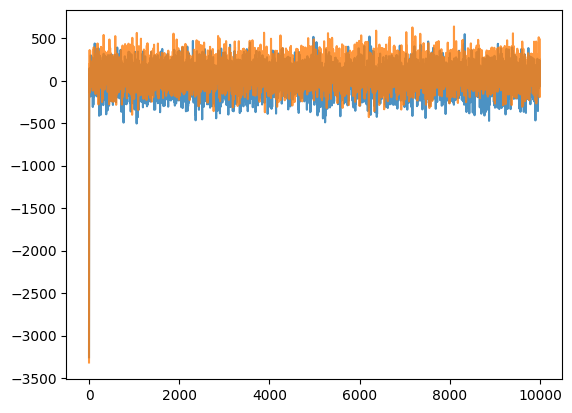

In [16]:
begin = 0
plt.plot(time1[begin:], press1[begin:], alpha=0.8)
plt.plot(time100[begin:], press100[begin:], alpha=0.8)
plt.show()

In [68]:
arr = np.arange(1, 11, dtype=int)
arr

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [69]:
mask = np.array([3, 4, 5])

In [75]:
np.argwhere((arr[mask] - 2) < 3).ravel()

array([0])

In [2]:
with open('../ff/trappe/trappe.top') as inp:
    text = inp.read()

In [6]:
parse_C6_C12(text, ['CA', 'OCA', 'CCA'])

{'CA': [0.00142, 2.52e-07],
 'OCA': [0.00203, 1.77e-06],
 'CCA': [0.00461, 1.44e-05]}

In [8]:
10000000 * 0.002

20000.0

---

In [1]:
import numpy as np
import MDAnalysis as mda
from tqdm import tqdm
import mdtraj as md
import sys

In [48]:
traj = md.load('../data/cal_dec_tip3p_center.xtc', top='../data/cal_dec_tip3p_center.gro')

In [57]:
len(traj.time.astype(int))

5001

In [62]:
10_000 % 300

100

In [ ]:
M = 10

In [53]:
chunk.time.astype(int)

array([10000])

In [19]:
block_lenght: float = 300
begin_time: float = 5_000
time: float = 10_000
timestep: float = 2
units: str = "ps"

assert units.lower() in ["ns", "ps"], "Wrong units format"
units = 1000 if units.lower() == "ns" else 1

N = int(time * units) // int(timestep * units) + 1
L = int((time - begin_time) * units) // int(block_lenght * units)
tau = int(block_lenght * units) // int(timestep * units)

start_frame = N - tau * L

In [20]:
start_frame

2601

In [3]:
for chunk in md.iterload('../data/cal_dec_tip3p_center.xtc', top='../data/cal_dec_tip3p_center.gro', chunk=tau, skip=start_frame):
    times = chunk.time.astype(int)
    print(chunk.time.astype(int), len(times))
    break

[  2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36
  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72
  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108
 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144
 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180
 182 184 186 188 190 192 194 196 198 200] 100


In [1]:
import numpy as np
from tqdm import tqdm
import mdtraj as md
import matplotlib.pyplot as plt

import os
import sys

sys.path.append("..")  # Avoid error with importing of src

from src.utils_py.stat_ineff import get_numerical_density_profile, get_center_pbc, apply_pbc, get_statistical_inefficiency_RCA

In [5]:
residue_mask = chunk.top.select(f"resname DECAN")
positions = chunk.xyz[:, residue_mask, :]
box = chunk.unitcell_lengths[:, np.newaxis, :]

# Calculating and centering aroud center mass with relative to the PBC
center = get_center_pbc(positions, box)
positions -= center
positions += box / 2
positions = apply_pbc(positions, box)

In [14]:
axis, dens = get_numerical_density_profile(positions, box, 200)

In [15]:
len(axis)

200

In [16]:
axis /= 9
dens /= 3.0896 * 10

In [17]:
np.trapz(dens, axis)

0.4998925314712175

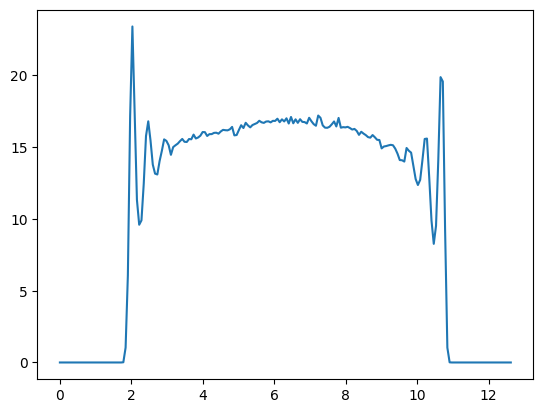

In [11]:
plt.plot(axis, dens)

In [61]:
H = 9
l, phi = 18.004 / H, 0.5
rho_bulk = 3.0896 * 10

# block_lenghts = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
block_lenghts = [8000, 9000, 10000]
# PHIs = []

for bl in block_lenghts:
    PHI = get_statistical_inefficiency_RCA(
        '../data/cal_dec_tip4p.xtc',
        '../data/cal_dec_tip4p.gro',
        rho_bulk,
        l,
        phi,
        H,
        'roll',
        'DECAN',
        200,
        block_lenght=bl,
        begin_time=5_000,
        time=40_000,
        timestep=2,
        display=False
    )

    PHIs.append(PHI)

100%|██████████| 4/4 [01:34<00:00, 23.55s/it]


X [135.88000488 137.9498291  137.51147461 ... 180.         180.
 141.70429038] 12.95935317072738
Y [132.71702013 132.79522871 130.72760906 128.38434462] 1.8020437661138893


100%|██████████| 3/3 [01:23<00:00, 27.68s/it]


X [148.4901123  149.86567998 139.83837891 ... 180.         180.
 141.70429038] 13.761288970580914
Y [133.63957723 131.02388467 127.84820654] 2.367998539020198


100%|██████████| 3/3 [01:31<00:00, 30.46s/it]

X [140.89306641 137.4534874  128.14123535 ... 180.         180.
 141.70429038] 13.229212586021667
Y [131.03308601 132.87107813 127.32586345] 2.306298621401813


In [62]:
block_lenghts = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [63]:
tau = np.array([35, 17, 11, 8, 7, 5, 5, 4, 3, 3])

In [25]:
Y = np.array([4.67527978879759, 3.672595302836527, 2.8022762311670824, 2.6240707370260625, 3.618539397524286, 1.8979680042298328, 2.2201292190023723, ])

In [26]:
X = np.array([12.847376874884809, 12.841816917507142, 12.870732834799009, 12.95935317072738, 12.847376874884809, 13.229212586021667, 12.847376874884809])

NameError: name 'block_lenghts' is not defined

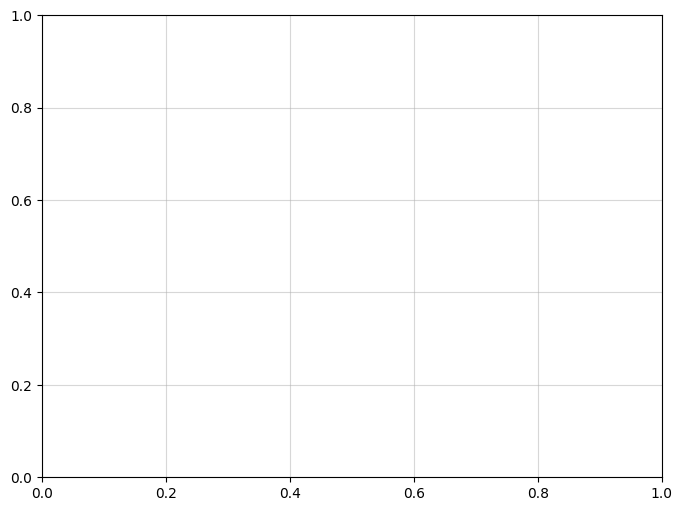

In [41]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

plt.hlines(1, block_lenghts[0] / 1000, block_lenghts[-1] / 1000, ls='--', colors='red')
plt.scatter(np.array(block_lenghts) / 1000, tau * Y/X)

plt.xlabel('tau, ns', fontsize=14)
plt.ylabel(r'$\tau \cdot \sigma(Y)_{\tau}/\sigma(X)$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(bottom=-0.1)
plt.show()

In [34]:
tau * Y / X

array([12.73682513,  4.86178245,  2.39497152,  1.6198776 ,  1.97159125,
        0.71733975,  0.86403989])

In [32]:
np.array(PHIs) / np.array(block_lenghts)

array([0.18195464, 0.1429936 , 0.10886234, 0.10124235, 0.14082795,
       0.07173397, 0.08640399])

In [13]:
PHIs

[181.95464468459863,
 285.98720309037486,
 326.5870250515743,
 404.9693997001826,
 704.1397307722264,
 430.40384872988034,
 604.8279226321034]

In [33]:
np.array(PHIs) * np.array([35, 17, 11, 8, 7, 5, 5]) / block_lenghts

array([6.36841256, 2.43089123, 1.19748576, 0.8099388 , 0.98579562,
       0.35866987, 0.43201994])

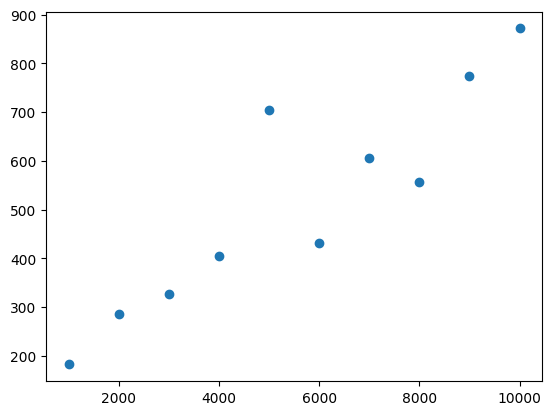

In [64]:
plt.scatter(block_lenghts, np.array(PHIs))

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
t1, en1 = np.loadtxt("../data/energy_T_393.xvg", comments=["@", "#"], unpack=True)
t2, en2 = np.loadtxt("../data/energy_2.5.xvg", comments=["@", "#"], unpack=True)

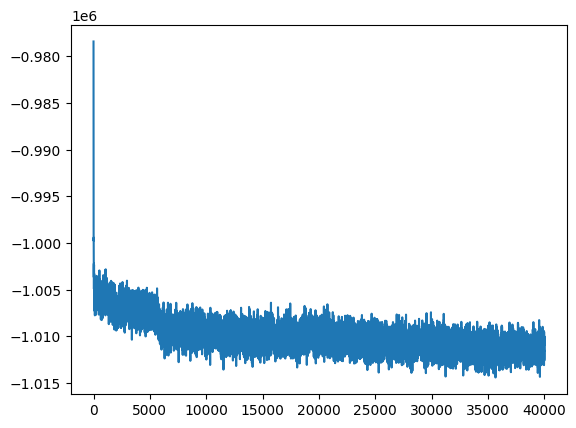

In [16]:
# begin = 5_000
# plt.plot(t1[begin:], en1[begin:])
plt.plot(t2, en2)

In [8]:
t, en = np.loadtxt("/home/fluffymelon/PANDA_exp/scaling/calcite_decane_tip4p_sc_2.0_offset/energy.xvg", comments=["@", "#"], unpack=True)
# t, en = np.loadtxt("/home/fluffymelon/PANDA_exp/scaling/calcite_decane_tip4p_sc_2.0/energy.xvg", comments=["@", "#"], unpack=True)

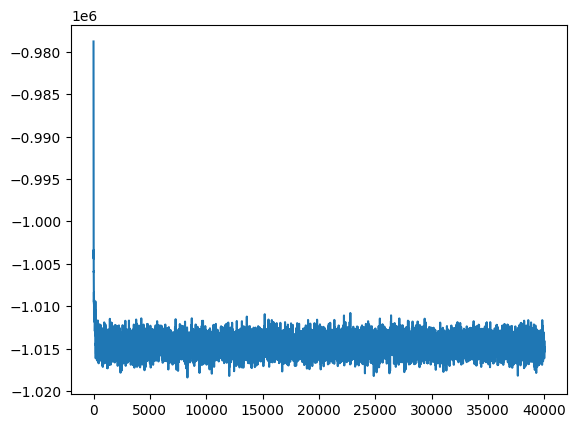

In [9]:
plt.plot(t, en)

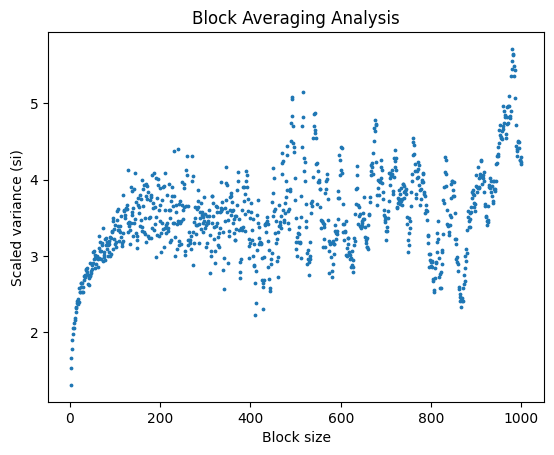

In [60]:
# Input array
begin = 5_000
x = en1[begin:] # Replace with your data

# Compute variance, mean, and length
v = np.var(x, ddof=1)  # ddof=1 for sample variance (like in R)
m = np.mean(x)
n = len(x)

si = []  # List to store the scaled variances
for t in range(2, 1001):  # Equivalent to seq(2, 1000)
    nblocks = n // t  # Number of blocks
    if nblocks > 0:
        # Create blocks of size `t`
        xg = np.split(x[:nblocks * t], nblocks)
        # Calculate mean of each block
        block_means = np.array([np.mean(block) for block in xg])
        # Variance of the block means
        v2 = np.sum((block_means - m) ** 2) / nblocks
        # Compute scaled variance and append
        si.append(t * v2 / v)
    else:
        break

# Plot the result
plt.scatter(range(2, 2 + len(si)), si, s=3)
plt.xlabel('Block size')
plt.ylabel('Scaled variance (si)')
plt.title('Block Averaging Analysis')
plt.show()


---

In [1]:
import mdtraj as md
import numpy as np
from tqdm import tqdm
import sys
import os
import matplotlib.pyplot as plt

sys.path.append("..")  # Avoid error with importing of src
from src.utils_py.stat_ineff import get_center_pbc, apply_pbc, get_numerical_density_profile
from src.utils_py.profile_approx import _profile_approx_alpha_from_array

In [27]:
trajectory_file = '/home/fluffymelon/PANDA_exp/scaling/calcite_decane_tip4p_sc_2.5/cal_dec_tip4p.xtc'
topology_file = '/home/fluffymelon/PANDA_exp/scaling/calcite_decane_tip4p_sc_2.5/cal_dec_tip4p.gro'
residue = 'DECAN'
H = 9
l, phi = 18.004 / H, 0.5
rho_bulk = 3.0896 * 10
interface_type = 'roll'
sl=200
block_lenght=1_000
begin_time=0
time=40_000
timestep=2
units=1
display=False

N = int(time * units) // int(timestep * units) + 1
L = int((time - begin_time) * units) // int(block_lenght * units)
tau = int(block_lenght * units) // int(timestep * units)
start_frame = N - tau * L

axises = []
denses = []
angles = []

for chunk in tqdm(
    md.iterload(trajectory_file, top=topology_file, chunk=tau, skip=start_frame),
    total=L,
):
    residue_mask = chunk.top.select(f"resname {residue}")
    positions = chunk.xyz[:, residue_mask, :]
    box = chunk.unitcell_lengths[:, np.newaxis, :]

    # Calculating and centering aroud center mass with relative to the PBC
    center = get_center_pbc(positions, box)
    positions -= center
    positions += box / 2
    positions = apply_pbc(positions, box)

    # Calculating contact angle for each frame
    for i in range(tau):
        axis_i, dens_i = get_numerical_density_profile(
            positions[i, :, :], box[i, :, :], sl, center=True
        )
        _, _, best_i = _profile_approx_alpha_from_array(
            dens_i, axis_i, rho_bulk, l, phi, H, interface_type, display
        )

        angles.append(np.rad2deg(best_i['theta']))
        axises.append(axis_i)
        denses.append(dens_i)

angles = np.array(angles)
axises = np.array(axises)
denses = np.array(denses)


 2%|█▊                                                                       | 1/40 [02:13<1:27:01, 133.88s/it]

KeyboardInterrupt: 

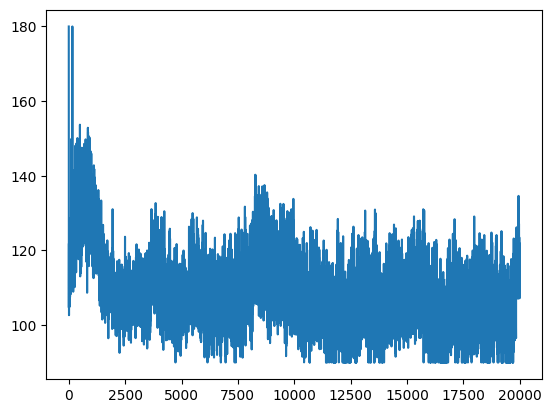

In [3]:
plt.plot(angles)

In [11]:
angles_trunc = angles.copy()

In [13]:
block_lenght = 2000

angles_trunc = []
for i in tqdm(range(len(denses)%block_lenght, len(denses), block_lenght)):
    mean_dens = np.mean(denses[i:i+block_lenght, :], axis=0)
    mean_axis = np.mean(axises[i:i+block_lenght, :], axis=0)

    _, _, best_i = _profile_approx_alpha_from_array(
        mean_dens, mean_axis, rho_bulk, l, phi, H, interface_type, display
    )

    # print(best_i['delta'] * 9)
    angles_trunc.append(np.rad2deg(best_i['theta']))

angles_trunc = np.array(angles_trunc)


00%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 156.81it/s]

In [22]:
angles_trunc_offset = angles_trunc.copy()

In [29]:
angles_trunc_offset

array([119.99930929, 107.67145352, 106.98241223, 106.57266677,
       110.91349262, 105.39012667, 102.35181603, 106.17524378,
        99.82295876, 103.11663408])

ValueError: x and y must be the same size

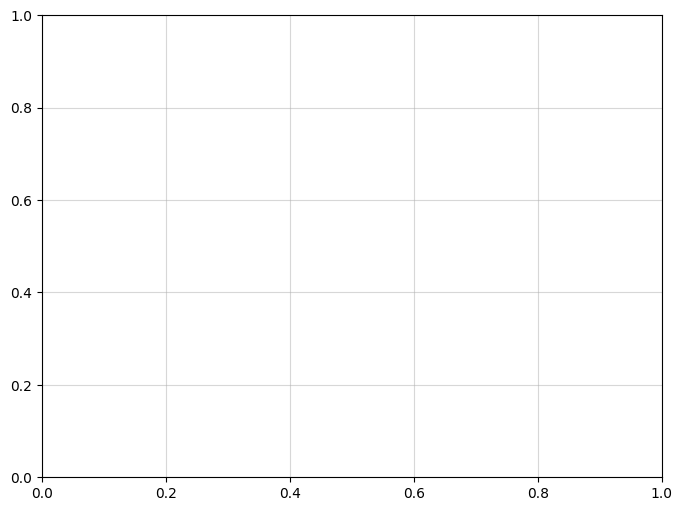

In [28]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

begin = 1
plt.scatter(range(len(denses)%block_lenght, len(denses), block_lenght)[begin:], angles_trunc_offset[begin:], label='{:.2f} +- {:.2f}'.format(np.mean(angles_trunc_offset[begin:]), np.std(angles_trunc_offset[begin:])))
plt.legend(fontsize=14)
plt.ylim(90, 180)
plt.show()

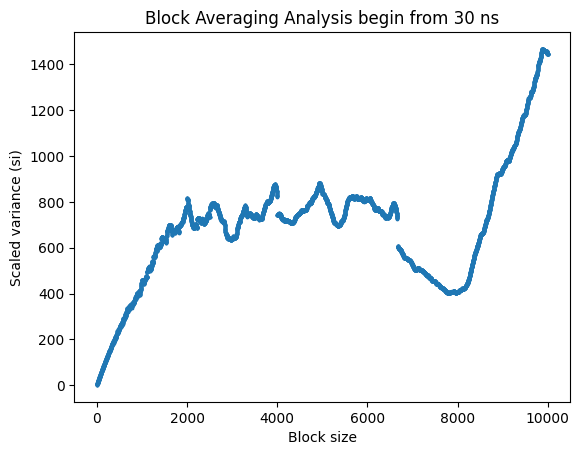

In [12]:
# Input array
begin = 0 // timestep // block_lenght
x = angles_trunc[begin:]

# Compute variance, mean, and length
v = np.var(x, ddof=1)  # ddof=1 for sample variance (like in R)
m = np.mean(x)
n = len(x)

si = []  # List to store the scaled variances
for t in range(2, 10001):  # Equivalent to seq(2, 1000)
    nblocks = n // t  # Number of blocks
    if nblocks > 0:
        # Create blocks of size `t`
        xg = np.split(x[:nblocks * t], nblocks)
        # Calculate mean of each block
        block_means = np.array([np.mean(block) for block in xg])
        # Variance of the block means
        v2 = np.sum((block_means - m) ** 2) / nblocks
        # Compute scaled variance and append
        si.append(t * v2 / v)
    else:
        break

# Plot the result
plt.scatter(range(2, 2 + len(si)), si, s=3)
plt.xlabel('Block size')
plt.ylabel('Scaled variance (si)')
plt.title('Block Averaging Analysis begin from 30 ns')
plt.show()


In [1]:
axises = np.array(axises)
denses = np.array(denses)

NameError: name 'np' is not defined

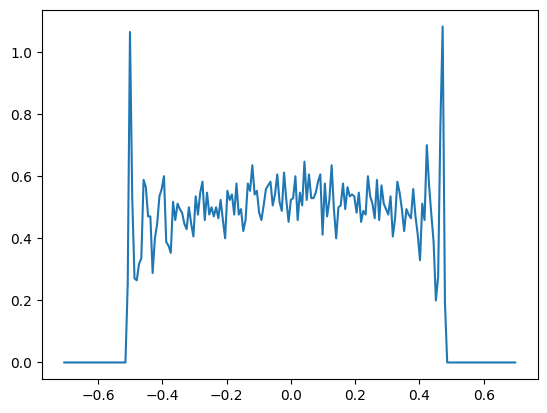

In [128]:
plt.plot(axises[-1], denses[-1, :])

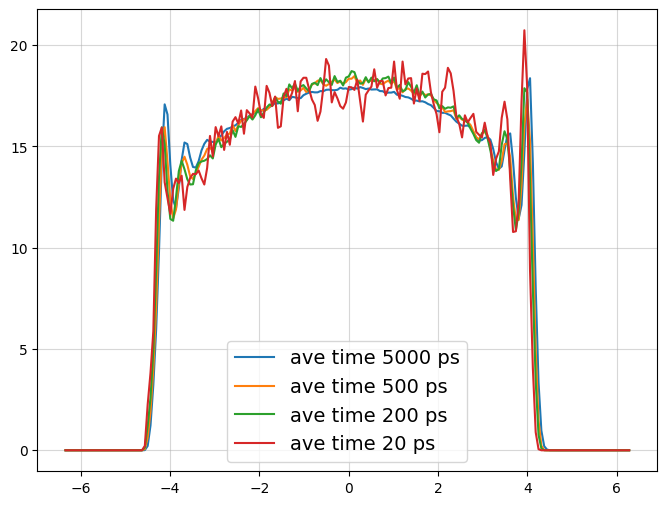

In [94]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

for begin in []:
    plt.plot(np.mean(axises[begin:], axis=0), np.mean(denses[begin:], axis=0), label=f'ave time {(2500 - begin) * 2} ps')

plt.legend(fontsize=14)

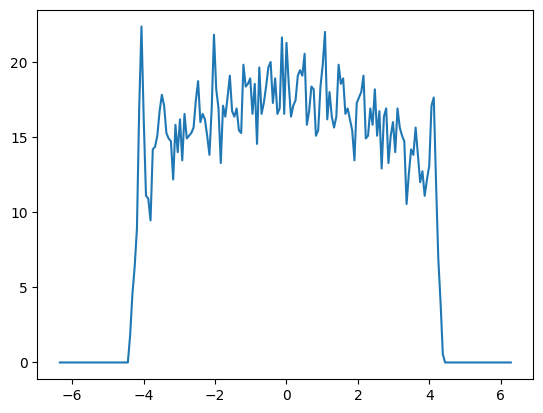

In [80]:
plt.plot(axises[1], denses[1])

In [81]:
axises.shape

(2500, 200)

In [126]:
axises.shape

(20000, 200)

In [148]:
arr = angles.reshape((angles.shape[0]//20, -1))

In [149]:
arr

array([[106.35341308,  94.0474243 ,  95.01219678, ...,  90.00082827,
         90.00607668,  96.15216565],
       [ 90.00082827,  90.00111553,  90.00111553, ...,  90.00041306,
         90.00041306,  90.00041306],
       [ 90.00041306,  90.00041306,  90.00041306, ...,  90.00041306,
         90.00041306,  90.00041306],
       ...,
       [122.87438965, 131.32836914, 124.57413983, ..., 130.73840332,
        129.21350312, 130.95136374],
       [129.85510254, 120.59692383, 122.65631318, ..., 121.04187012,
        124.17852721, 130.66693921],
       [123.83292961, 128.17419434, 126.82617187, ..., 110.37846708,
        119.28515625, 118.14796387]])